# Imports

In [1]:
import xgboost as xgb
from autograd import grad, hessian, elementwise_grad
import pandas as pd
import matplotlib.pyplot as plt
import autograd.numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Layer
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

from scipy.stats import percentileofscore
import time
import math

# Training data

In [2]:
df = pd.read_parquet('../pipeline/tmp/cities/poz-w/dataset_50_stops.parquet')
df.head(5)

,from_x,from_y,to_x,to_y,day_type,start,reference,time
0,0.994687,-1.925553,-0.141699,0.518964,0,0.504468,3251,5715
1,0.994687,-1.925553,0.216683,-0.231768,0,0.504468,1627,3158
2,-0.767035,1.589467,0.254793,0.689781,2,0.099178,2657,8527
3,0.455074,-0.001201,0.078837,0.048088,1,0.783380,744,1394
4,-1.071253,-0.765113,0.302267,-0.454654,0,0.679792,3483,5585


In [3]:
print(df.size)

32000000


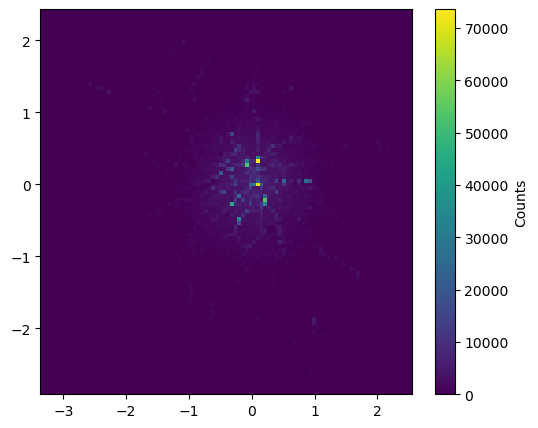

In [4]:
x = df['to_x']
y = df['to_y']

plt.figure(figsize=(6, 5))
plt.hist2d(x, y, bins=100, cmap='viridis')

plt.colorbar(label='Counts')

In [5]:
X = df[['from_x', 'from_y', 'to_x', 'to_y', 'day_type', 'start']]
y = df['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

class MaxValueScaler:
    def fit(self, data):
        self.max_value = np.max(data)
        return self

    def transform(self, data):
        return data / self.max_value

    def inverse_transform(self, data):
        return data * self.max_value
 
scaler = MaxValueScaler()
y_train_scaled = scaler.fit(y_train.values.reshape(-1, 1)).transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
"""
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))"""  
 

'\nscaler = MinMaxScaler()\ny_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))\ny_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))'

In [6]:
dtrain = xgb.DMatrix(X_train, label=y_train_scaled)
dtest = xgb.DMatrix(X_test, label=y_test_scaled)
mean_y_train_scaled = np.mean(y_train_scaled)

In [7]:
"""
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
mean_y_train = np.mean(y_train)"""

'\ndtrain = xgb.DMatrix(X_train, label=y_train)\ndtest = xgb.DMatrix(X_test, label=y_test)\nmean_y_train = np.mean(y_train)'

# Model definitions

## parameters

### NN

In [8]:
model = Sequential([
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(256, activation='relu', kernel_initializer=HeNormal()),
    Dense(128, activation='relu', kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(4, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='exponential'),
])

### XGB

In [19]:
params = {
    #'reg:squarederror'
    'max_depth': 6,
    'eta': 0.5,
    'seed': 7,
    'base_score': mean_y_train_scaled
}
num_rounds = 1000

## loss function

### NN

In [10]:
def quadrtic(ratio):
    return (1-ratio)**2

def squized_sigmoid(ratio):
    return 1/(1 + tf.math.exp(-30*(ratio-1)))

In [11]:
def asymetric_loss_function(y_true, y_pred):
    #y_true = tf.cast(y_true, tf.float32)
    #y_pred = tf.cast(y_pred, tf.float32)
    
    #tf.print("y_true:", y_true, summarize=-1)
    #tf.print("y_pred:", y_pred, summarize=-1)

    tf.debugging.assert_all_finite(y_pred, "y_pred contains NaN values!")
    
    tf.debugging.assert_greater_equal(
        tf.reduce_min(y_pred), tf.constant(0.0, dtype=tf.float32),
        message=f"y_pred contains negative values! {y_pred}"
    )

    ratio = y_pred / y_true
    
    tf.debugging.assert_non_negative(
        ratio,
        message="Ratio is negative!"
    )
    sigmoid = squized_sigmoid(ratio)
    loss = quadrtic(ratio)*(1-sigmoid)+3*ratio*sigmoid

    return tf.reduce_mean(loss)

### XGB

In [12]:
def np_asymetric_loss_function(y_true, y_pred):
    #print("y_true:", y_true, "  y_pred: ", y_pred)
    #return (y_pred - y_true)**2
    y_pred = abs(y_pred)

    ratio = y_pred / y_true
    
    def quadratic(ratio):
        return (1 - ratio) ** 2
    
    def squeezed_sigmoid(ratio):
        return 1 / (1 + np.exp(-30 * (ratio - 1)))
    
    sigmoid = squeezed_sigmoid(ratio)
    loss = quadratic(ratio) * (1 - sigmoid) + 3 * ratio * sigmoid
    return loss

def xgb_eval_metric(preds, dtrain):
    labels = dtrain.get_label()
    #print('labels: ', labels)
    #print('preds: ', preds)
    metric_name = "asymetric_loss"
    metric_value = np.mean(np_asymetric_loss_function(labels, preds))
    return metric_name, metric_value

In [13]:
grad_asymetric_loss = elementwise_grad(np_asymetric_loss_function)
hess_asymetric_loss = elementwise_grad(grad_asymetric_loss)
gradients_list = []
hessians_list = []
loss_list = []

def xgb_custom_obj(preds, dtrain):
    #print("preds: ", preds)
    labels = dtrain.get_label()
    #print("labels: ", labels)
    grad = grad_asymetric_loss(labels, preds)
    #print("grad magnitude: ", np.linalg.norm(grad))
    #print("grad: ", grad)
    #hess = hess_asymetric_loss(labels, preds)
    hess = np.ones_like(preds) 

    # Debugging: Check for NaN or Inf values
    if np.any(np.isnan(grad)) or np.any(np.isnan(hess)):
        print("NaN values found in gradients or Hessians")
    if np.any(np.isinf(grad)) or np.any(np.isinf(hess)):
        print("Inf values found in gradients or Hessians")

    loss = np_asymetric_loss_function(labels, preds)
    """
    print("preds", preds)
    print("Labels:", labels)
    print("Loss:", loss)
    print("Gradients:", grad)
    print("Hessians:", hess)
    """
    gradients_list.append(np.mean(grad))
    hessians_list.append(np.mean(hess))
    loss_list.append(np.mean(loss))
    return grad, hess

def compute_grad_and_hess(predt: np.ndarray, dtrain: xgb.DMatrix):
    """Custom objective function for XGBoost."""
    y_true = dtrain.get_label()  # Extract true labels
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    predt = tf.convert_to_tensor(predt, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as outer_tape:
        outer_tape.watch(predt)
        with tf.GradientTape() as inner_tape:
            inner_tape.watch(predt)
            # Compute the loss
            ratio = predt / y_true
            quadratic = (1 - ratio) ** 2
            squized_sigmoid = 1 / (1 + tf.exp(-30 * (ratio - 1)))
            loss = tf.reduce_mean(quadratic * (1 - squized_sigmoid) + 3 * ratio * squized_sigmoid)
        # Compute the gradient
        grad = inner_tape.gradient(loss, predt)
    # Compute the Hessian
    hess = outer_tape.gradient(grad, predt)
    del outer_tape  # Free memory

    print("Gradients:", grad)
    print("Hessians:", hess)
    
    return grad.numpy(), hess.numpy()

In [14]:
def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the gradient squared log error.'''
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
    '''Compute the hessian for squared log error.'''
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))

def squared_log(predt: np.ndarray,
                dtrain: xgb.DMatrix):
    '''Squared Log Error objective. A simplified version for RMSLE used as
    objective function.
    '''
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

In [15]:
import numpy as np

def simple_loss_function(y_true, y_pred):
    # Compute the ratio
    ratio = y_pred / (y_true * 0.8)
    
    # Compute loss
    loss = np.where(
        ratio < 1,
        1 - ratio,                # If ratio < 1
        10 * (ratio - 1)          # If ratio > 1
    )
    return loss

def custom_grad_hess(y_true, y_pred):
    # Compute the ratio
    ratio = y_pred / (y_true * 0.8)
    
    # Gradient
    grad = np.where(
        ratio < 1,
        -1 / (y_true * 0.8),      # Gradient for ratio < 1
        10 / (y_true * 0.8)       # Gradient for ratio > 1
    )
    
    # Hessian (second derivative)
    #hess = np.zeros_like(y_pred)  # Hessian is zero since the loss is piecewise linear
    hess = np.ones_like(y_pred) * 1e-6
    
    return grad, hess

def xgb_simple_obj(preds, dtrain):
    labels = dtrain.get_label()
    grad, hess = custom_grad_hess(labels, preds)
    
    print("y_true:", labels)
    print("y_pred:", preds)
    print("Gradient:", grad)
    print("Hessian:", hess)
    return grad, hess


In [16]:
def differentiable_loss(y_true, y_pred):
    # Compute the ratio
    ratio = y_pred / (y_true * 0.8)
    # Compute the loss
    loss = (1 - ratio) ** 2
    return loss

def differentiable_grad_hess(y_true, y_pred):
    # Gradient
    grad = (25*y_pred - 20*y_true)/(8*(y_true**2))
    
    # Hessian
    hess = 25/(y_true**2)
    
    return grad, hess

def xgb_differentiable_obj(preds, dtrain):
    labels = dtrain.get_label()
    grad, hess = differentiable_grad_hess(labels, preds)
    return grad, hess


# Training

### NN

In [17]:
model.compile(optimizer='adam', loss=asymetric_loss_function, metrics=['mape'])
history = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_split=0.2)

Epoch 1/16
23834/80000 [=======>......................] - ETA: 1:36 - loss: 0.8364 - mape: 87.3010

KeyboardInterrupt: 

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # Enable TensorFlow Select ops.
]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpfpa54k7d\assets


### XGB

In [ ]:
def test_grad_hess():
    y_true = np.array([1.0, 2.0, 3.0])
    y_pred = np.array([1.1, 1.9, 3.5])

    grad = grad_asymetric_loss(y_true, y_pred)
    hess = hess_asymetric_loss(y_true, y_pred)

    print("y_true:", y_true)
    print("y_pred:", y_pred)
    print("Gradient:", grad)
    print("Hessian:", hess)

test_grad_hess()

TypeError: loop of ufunc does not support argument 0 of type ArrayBox which has no callable exp method

In [20]:
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, obj=xgb_differentiable_obj, verbose_eval=50)
#xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, obj=squared_log, verbose_eval=10)
#xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10)

[0]	train-rmse:0.09630	eval-rmse:0.09645
[50]	train-rmse:0.07846	eval-rmse:0.07866
[100]	train-rmse:0.06849	eval-rmse:0.06865
[150]	train-rmse:0.06395	eval-rmse:0.06409
[200]	train-rmse:0.06194	eval-rmse:0.06207
[250]	train-rmse:0.06061	eval-rmse:0.06074
[300]	train-rmse:0.05956	eval-rmse:0.05969
[350]	train-rmse:0.05867	eval-rmse:0.05880
[400]	train-rmse:0.05803	eval-rmse:0.05816
[450]	train-rmse:0.05747	eval-rmse:0.05760
[500]	train-rmse:0.05708	eval-rmse:0.05721
[550]	train-rmse:0.05659	eval-rmse:0.05673
[600]	train-rmse:0.05619	eval-rmse:0.05633
[650]	train-rmse:0.05588	eval-rmse:0.05603
[700]	train-rmse:0.05563	eval-rmse:0.05578
[750]	train-rmse:0.05536	eval-rmse:0.05551
[800]	train-rmse:0.05517	eval-rmse:0.05532
[850]	train-rmse:0.05498	eval-rmse:0.05513
[900]	train-rmse:0.05477	eval-rmse:0.05493
[950]	train-rmse:0.05458	eval-rmse:0.05474
[999]	train-rmse:0.05440	eval-rmse:0.05457


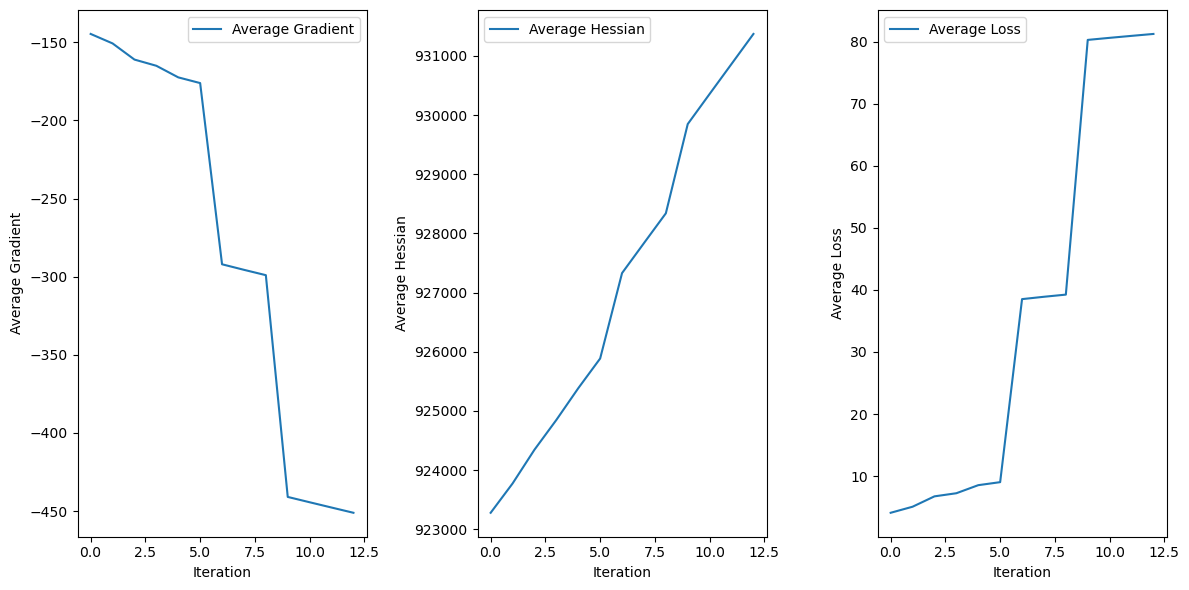

In [43]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(gradients_list, label='Average Gradient')
plt.xlabel('Iteration')
plt.ylabel('Average Gradient')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(hessians_list, label='Average Hessian')
plt.xlabel('Iteration')
plt.ylabel('Average Hessian')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(loss_list, label='Average Loss')
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
batch_size = 10000

# Create batches of DMatrix
num_batches = int(np.ceil(X_train.shape[0] / batch_size))
dtrain_batches = [xgb.DMatrix(X_train[i*batch_size:(i+1)*batch_size], label=y_train[i*batch_size:(i+1)*batch_size]) for i in range(num_batches)]
# Initialize the Booster
model = None
evals = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model with custom loss function and custom evaluation function in batches
num_rounds_per_batch = 100
total_rounds = 10000
rounds_per_batch = total_rounds // num_batches

for i, dtrain_batch in enumerate(dtrain_batches):
    print(f"Training on batch {i+1}/{num_batches}")
    if model is None:
        model = xgb.train(params, dtrain_batch, rounds_per_batch, evals=evals, obj=xgb_custom_obj, feval=xgb_eval_metric, verbose_eval=10)
        #xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10)
    else:
        model = xgb.train(params, dtrain_batch, rounds_per_batch, evals=evals, obj=xgb_custom_obj, feval=xgb_eval_metric, verbose_eval=10, xgb_model=model)
        #xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, verbose_eval=10, xgb_model=model)

Training on batch 1/320


c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\xgboost\training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
c:\Users\User\anaconda3\envs\BSC-thesis-deep-learning\lib\site-packages\autograd\numpy\numpy_vjps.py:53: RuntimeWarning: overflow encountered in square
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))


[0]	train-rmse:0.09838	train-asymetric_loss:0.00410	eval-rmse:0.09852	eval-asymetric_loss:0.00410
[10]	train-rmse:0.09838	train-asymetric_loss:0.00410	eval-rmse:0.09852	eval-asymetric_loss:0.00410
[20]	train-rmse:0.09838	train-asymetric_loss:0.00410	eval-rmse:0.09852	eval-asymetric_loss:0.00410
[30]	train-rmse:0.09838	train-asymetric_loss:0.00410	eval-rmse:0.09852	eval-asymetric_loss:0.00410
Training on batch 2/320
[0]	train-rmse:0.09838	train-asymetric_loss:0.00410	eval-rmse:0.09852	eval-asymetric_loss:0.00410


KeyboardInterrupt: 

# Quantization

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply float16 quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_float16_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpmwdlzqsx\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpmwdlzqsx\assets


In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply dynamic range quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_dynamic_range_quant.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpjek6xcih\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpjek6xcih\assets


In [19]:
X_test_uint8 = ((X_test / np.max(X_test)) * 255).astype(np.uint8)
X_train_uint8 = ((X_train / np.max(X_train))*255).astype(np.uint8)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply full integer quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Provide a representative dataset
def representative_dataset():
    for _ in range(100000):
        # Get sample input data as a numpy array in the correct shape
        yield [X_train_uint8[:1]]

converter.representative_dataset = representative_dataset

# Ensure that input and output tensors are quantized
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8

# Convert the model
tflite_model = converter.convert()

# Save the quantized TensorFlow Lite model
with open('model_full_integer_quant.tflite', 'wb') as f:
    f.write(tflite_model)

ValueError: Cannot losslessly cast from float64 to uint8

# Model evaluation

## Read tflite model

In [22]:
with open('model.tflite', 'rb') as f:
    tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.resize_tensor_input(input_details[0]['index'], (1, 6))
interpreter.allocate_tensors()

## predicitons on test set

### NN

In [23]:
nn_y_pred = []

for i in range(X_test.shape[0]):
    # single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    nn_y_pred.append(output_data[0][0])

nn_y_pred = np.array(nn_y_pred)

mape = mean_absolute_percentage_error(y_test, nn_y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')

Mean Absolute Percentage Error (MAPE): 55.73%


### XGB

In [24]:
y_pred_scaled = abs(xgb_model.predict(dtest))
xgb_y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
print(y_test.shape)
# Evaluate the model using Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, xgb_y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%')
print(xgb_y_pred.shape)

(800000,)
Mean Absolute Percentage Error (MAPE): 25.72%
(800000, 1)


## Visualize set results distribution

### code

In [25]:
def plot_results_distribution(y_pred):    
    percentage_difference = ((y_pred - y_test) / y_test) * 100
    #percentage_difference = y_pred - y_test

    percentile_1 = np.percentile(percentage_difference, 1)
    percentile_99 = np.percentile(percentage_difference, 99.9)
    max_overestimation = np.max(percentage_difference)
    percentile_of_0 = percentileofscore(percentage_difference, 0)

    plt.figure(figsize=(10, 6))
    sns.histplot(percentage_difference, kde=True, bins=100, color='blue')

    plt.axvline(percentile_1, color='green', linestyle='--', linewidth=2, label=f'1st Percentile: {percentile_1:.2f}%')
    plt.axvline(percentile_99, color='red', linestyle='--', linewidth=2, label=f'99.9th Percentile: {percentile_99:.2f}%')

    plt.text(percentile_1, plt.ylim()[1] * 0.9, f'{percentile_1:.2f}%', color='green', ha='center')
    plt.text(percentile_99, plt.ylim()[1] * 0.9, f'{percentile_99:.2f}%', color='red', ha='center')

    plt.axvline(max_overestimation, color='purple', linestyle='--', linewidth=2, label=f'Max Overestimation: {max_overestimation:.2f}%')
    plt.text(max_overestimation, plt.ylim()[1] * 0.8, f'{max_overestimation:.2f}%', color='purple', ha='center')

    plt.xlabel('Percentage Difference (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Percentage Difference Between Predictions and Targets')
    plt.legend()
    plt.show()

    print(f'Maximal Overestimation Value: {max_overestimation:.2f}%')
    print(f'Percentile for 0 on x-axis value: {percentile_of_0:.2f}%')

### NN

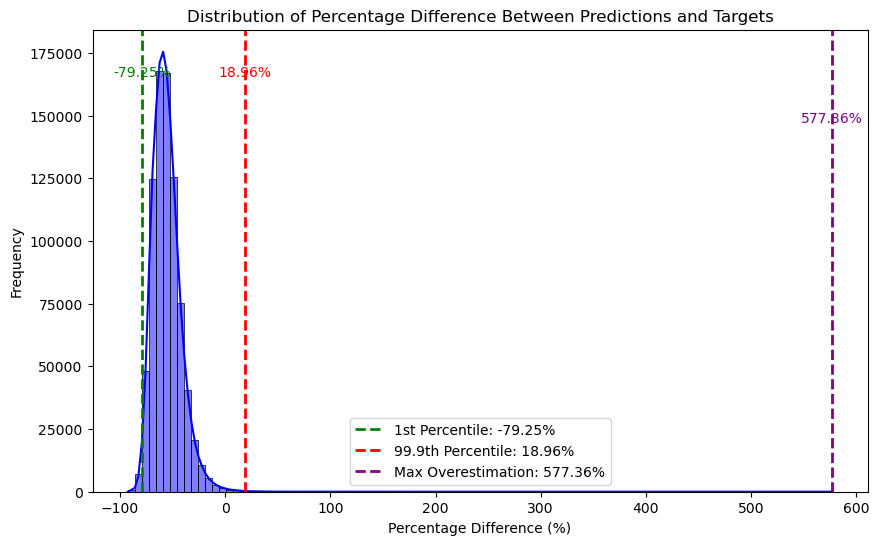

Maximal Overestimation Value: 577.36%
Percentile for 0 on x-axis value: 99.67%


In [27]:
plot_results_distribution(nn_y_pred)

### XGB

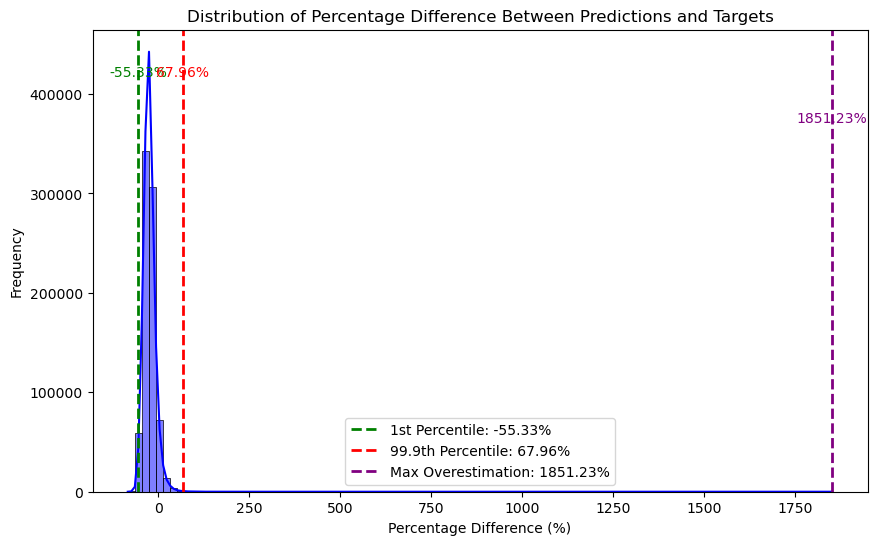

Maximal Overestimation Value: 1851.23%
Percentile for 0 on x-axis value: 92.99%


In [26]:
xgb_y_pred = xgb_y_pred.flatten()
plot_results_distribution(xgb_y_pred)

## Forward pass time

In [40]:
num_iterations = 10000
total_time = 0

for _ in range(num_iterations):
    random_index = np.random.randint(0, X_test.shape[0])
    # single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float64)
    single_row = X_test.iloc[i].to_numpy().reshape(1, -1).astype(np.float32)
    start_time = time.perf_counter()
    interpreter.set_tensor(input_details[0]['index'], single_row)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    end_time = time.perf_counter()
    total_time += (end_time - start_time)

average_forward_pass_time = (total_time / num_iterations) * 1e6
print(f"Average forward pass time for a single row using TensorFlow Lite: {average_forward_pass_time:.6f} microseconds")
print(f"total time for 10000 rows: {total_time*1000} milliseconds")

Average forward pass time for a single row using TensorFlow Lite: 8.108460 microseconds
total time for 10000 rows: 81.08460056246258 milliseconds
